# Un deuxième problème d'apprentissage

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
import torch

%matplotlib inline

In [5]:
A = pd.read_csv("traindata.csv")
A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_1     210 non-null    float64
 1   x_2     210 non-null    float64
 2   y       210 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 5.0 KB


<AxesSubplot:xlabel='x_1', ylabel='x_2'>

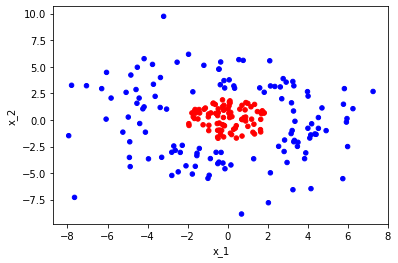

In [3]:
# On visualise
A.plot.scatter(x="x_1",y="x_2",c=["r" if e==1 else "b" for e in A.y])

In [6]:
# On centre et on réduit les entrées
X = scale(A.loc[:,["x_1","x_2"]])

## Questions:
> 1. Combien d'exemples contient l'ensemble d'entraînement?
> 2. Quel est le domaine des instances?
> 3. De quel type de problème d'apprentissage s'agit-il? Pourquoi?
> 4. Est-ce un problème linéairement séparable? Que pourrait-on faire pour le rendre linéairement séparable?
> 5. Codez un perceptron multi-couche avec 1 couche cachée de 3 unités.

In [5]:
# nb d'exemples
print(len(A))

210


-7.9383678372 7.26540503072
-8.84492273445 9.750874149460001


<AxesSubplot:>

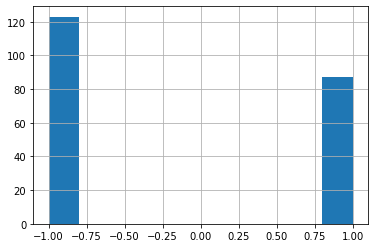

In [6]:
print(A.x_1.min(), A.x_1.max())
print(A.x_2.min(), A.x_2.max())
A.y.hist()
# L'ensemble R² (x_1,x_2)

C'est un problème de classification. Le vecteur de prédiction, y, est composé que de 1 et -1.

Le problème n'est pas linéairement séparable. Si on transforme x_1, x_2 en x_1² et x_2² on peut trouver une séparation

<AxesSubplot:xlabel='x_1', ylabel='x_2'>

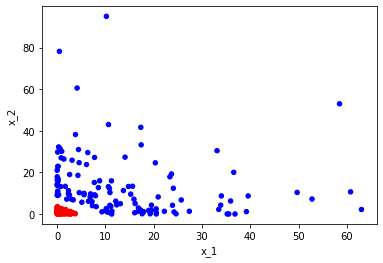

In [7]:
AA = A.copy()
AA.x_1 = AA.x_1 ** 2
AA.x_2= AA.x_2** 2
AA.plot.scatter(x="x_1",y="x_2",c=["r" if e==1 else "b" for e in A.y])

# 5. Gradient

On a la fonction 

$$\mathop Ls(\Theta)= \sum_{i \mathop{=} 1} ^ n log(1 + exp(y(i) G(x)))$$

On cherche à dériver 
$$\mathop log(1 + exp(y(i) G(x)))$$

La fonction est de la forme:
$$\mathop log(f(X))$$
Tq : 
$$\mathop f(X) = 1 + exp(y(i) G(x))$$

La dérivée est donc:
$$\mathop f'(X) / f(X)$$

$$\mathop exp[y(i)G(x)]' / f(X)$$

On a donc :
$$\mathop exp[y(i)G(x)]' = [y(i)G(x)]' * exp(y(i)G(x))$$




Arrivé ici, je n'arrive pas à dérivé  

$$\mathop g_{\Theta}(\mathbf{x})=w^{(2)T}\cdot \textrm{relu}\left(w^{(1)T}\cdot\mathbf{x}+b^{(1)}\right)+b^{(2)}$$

# 6. Gradient Descent

In [7]:
import torch

Xtensor = torch.tensor(X.astype(np.float32))
ytensor = torch.tensor(A.y.replace(-1,0).astype(np.float32)).unsqueeze(-1)

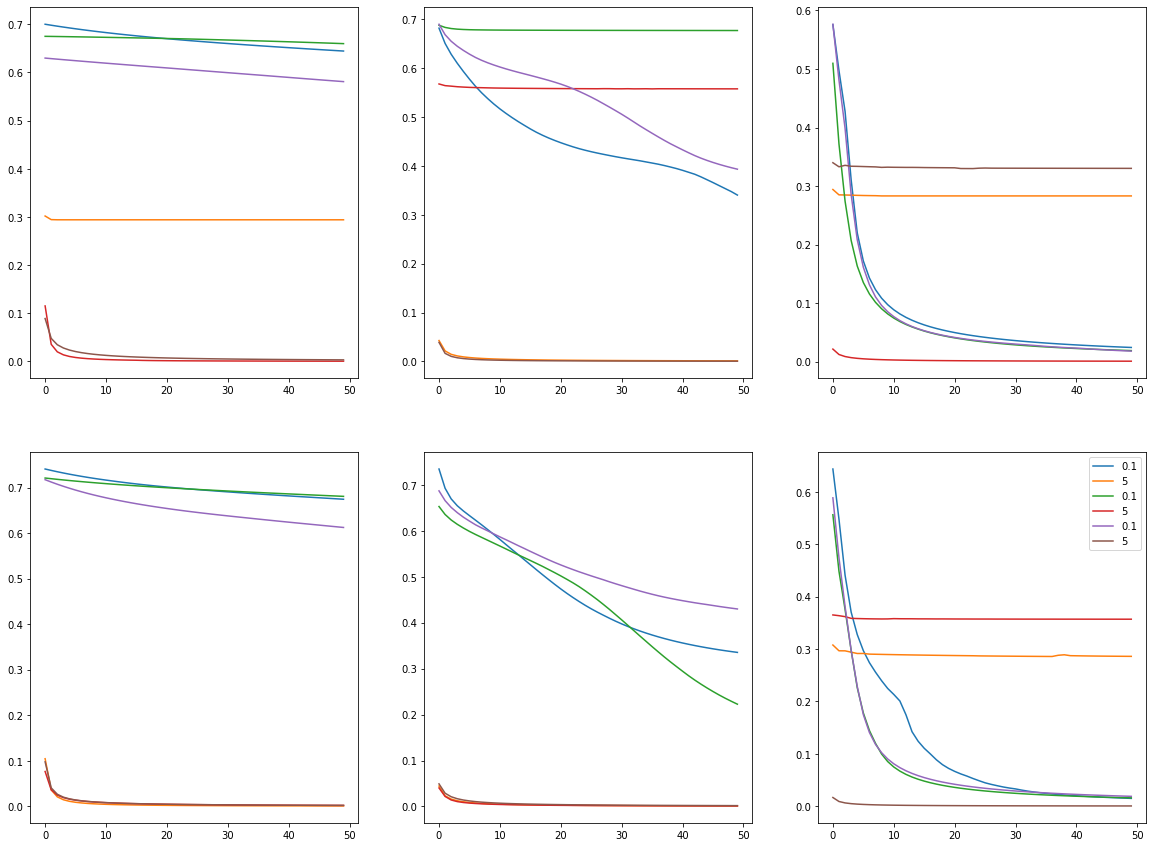

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,15))

learning_rates = [ 1e-3, 1e-2, 1e-1, 1, 2, 5]
loss_fn = torch.nn.BCELoss()
gd_loss_descent = np.array([])

k = 0
for s in range(6):
    for lr in learning_rates:
        loss_descent = []
        model = torch.nn.Sequential(
            torch.nn.Linear(2, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, 1),
            torch.nn.Sigmoid()
            )
        for t in range(5000):
            y_pred = model(Xtensor) # forward pass
            loss = loss_fn(y_pred, ytensor)

            if t % 100 == 99:
                loss_descent.append(loss.item())

            model.zero_grad()
            loss.backward()
            with torch.no_grad():
                for param in model.parameters():
                    param -= lr * param.grad
        if k >= 3:
            k = 0
        ax[int(s/3)][k].plot(loss_descent, label=str(lr))
        
        k += 1
        gd_loss_descent = np.append(gd_loss_descent, loss_descent)
        gd_loss_descent = gd_loss_descent.reshape(len(loss_descent),-1)
        
plt.legend()        
plt.show()

- On remarque que un petit pas de gradient prend du temps pour converger.
- On remarque que un grand pas de gradient ne converge pas nécéssairement.
- On remarque aussi que l'étape d'init joue un rôle. On n'arrive pas toujours au même résultat avec le même pas.

# 7. SGD

In [28]:
import torch.optim as optim

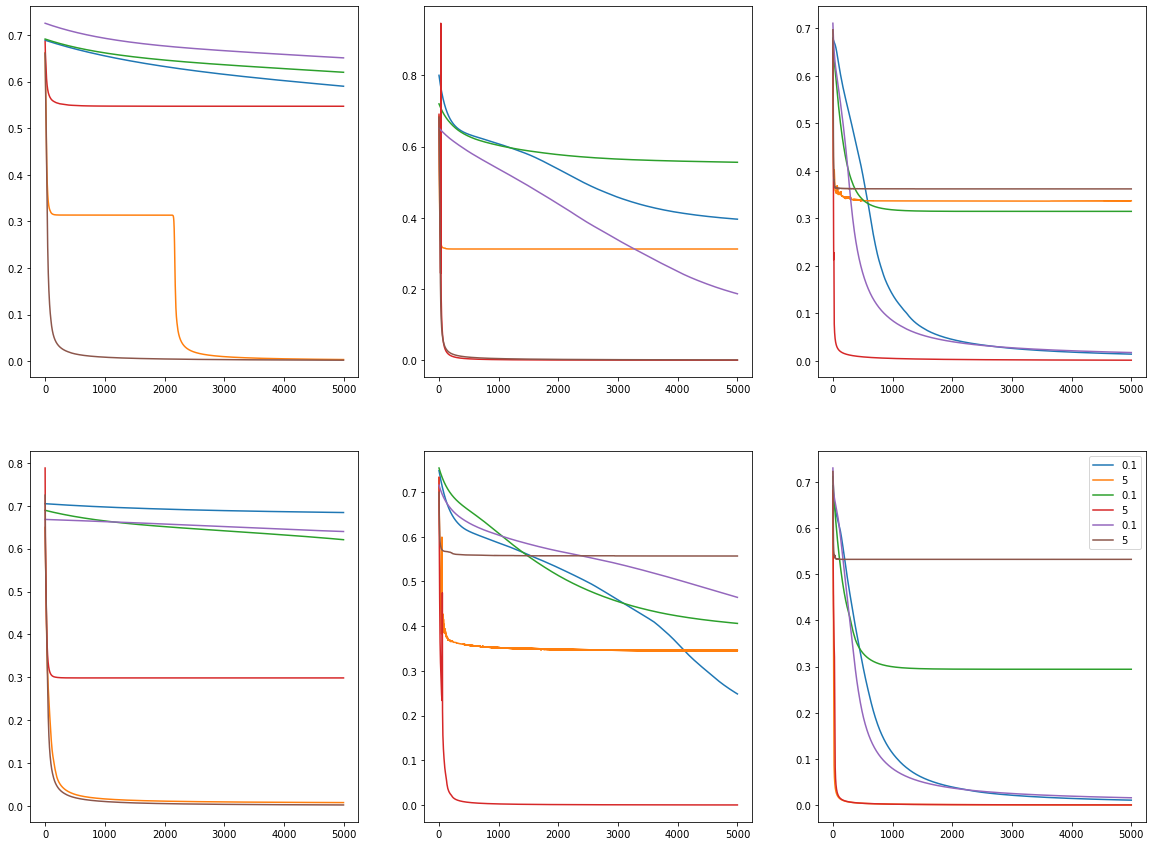

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,15))

loss_fn = torch.nn.BCELoss()
learning_rates = [ 1e-3, 1e-2, 1e-1, 1, 2, 5]

k = 0
for s in range(6):
    for lr_i in learning_rates:
        loss_descent = []
        model = torch.nn.Sequential(
            torch.nn.Linear(2, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, 1),
            torch.nn.Sigmoid()
            )
        optimizer = optim.SGD(model.parameters(), lr=lr_i)


        for t in range(5000):
            optimizer.zero_grad()
            y_pred = model(Xtensor) # forward pass
            loss = loss_fn(y_pred, ytensor)
            loss_descent.append(loss.item())

            loss.backward()
            optimizer.step()
            
        if k >= 3:
            k = 0
        ax[int(s/3)][k].plot(loss_descent, label=str(lr_i))        
        k += 1

plt.legend()
plt.show()

In [33]:
def SGD(X, y, lr, batch_size=10, verbose=False):
    loss_fn = torch.nn.BCELoss()
    model = torch.nn.Sequential(
        torch.nn.Linear(2, 3),
        torch.nn.ReLU(),
        torch.nn.Linear(3, 1),
        torch.nn.Sigmoid()
        )
    loss_descent = []
    m = X.size()[0]
    perm = torch.randperm(m)
    
    for e in range(5000):
        for i in range(0,m,batch_size):
            indices = perm[i:i+batch_size]
            batch_x, batch_y = X[indices], y[indices]
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)
            model.zero_grad()
            loss.backward()
            with torch.no_grad():
                for param in model.parameters():
                    param -= lr * param.grad
        if e % 100 == 99:
            if verbose:
                print("lr: " + str(lr) + ", epoch: " + str(e) + ", loss: " + str(loss.item()))
            loss_descent.append(loss.item())
    return loss_descent

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xtensor, ytensor, test_size=0.33, random_state=42)

print("X_train.shape : " + str(X_train.shape))
print("X_test.shape : " + str(X_test.shape))
print("y_train.shape : " + str(y_train.shape))
print("y_test.shape : " + str(y_test.shape))

X_train.shape : torch.Size([140, 2])
X_test.shape : torch.Size([70, 2])
y_train.shape : torch.Size([140, 1])
y_test.shape : torch.Size([70, 1])


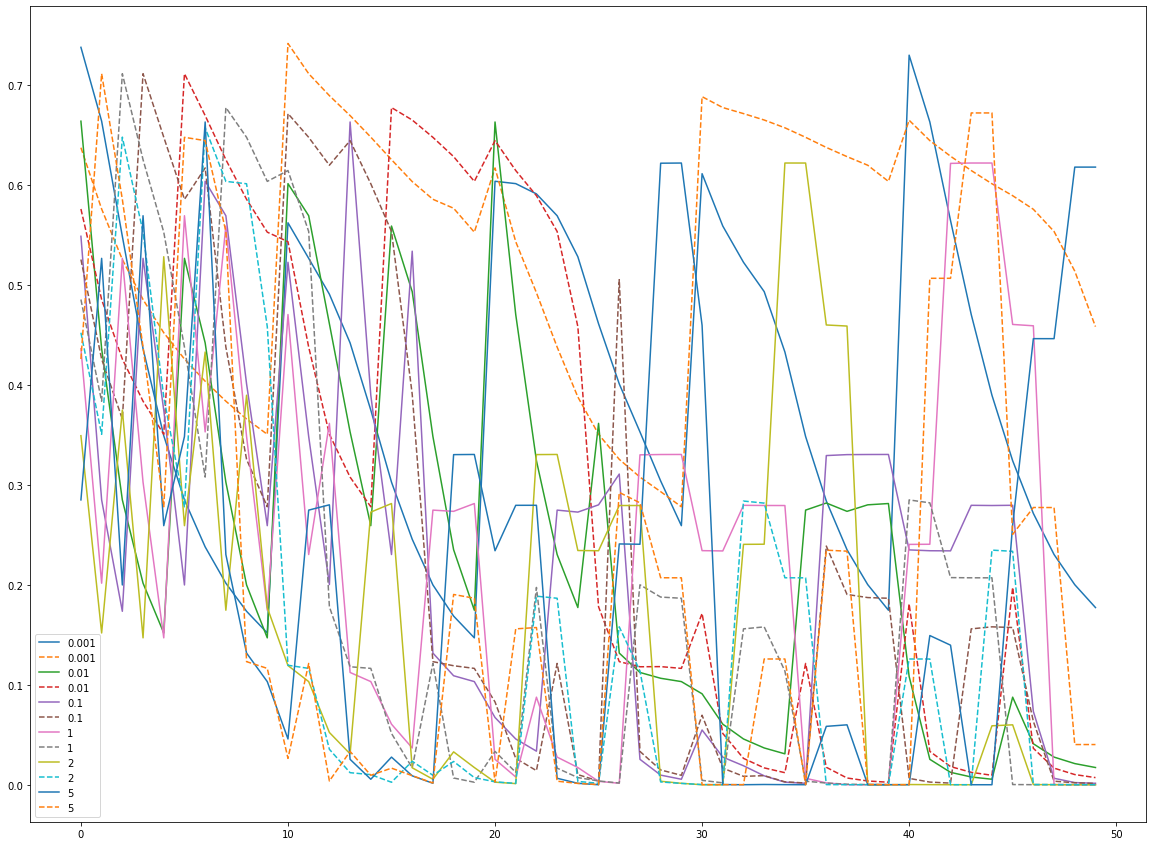

In [47]:
plt.figure(figsize=(20,15))

learning_rates = [1e-3, 1e-2, 1e-1, 1, 2, 5]
batch_size = 10

sgd_loss_descent_train = np.array([])
sgd_loss_descent_test = np.array([])

k = 0
for lr_i in learning_rates:
    tmp_loss_train = np.array([])
    tmp_loss_test = np.array([])
    for rep in range(5):
        tmp_loss_train = np.append(tmp_loss_train, SGD(X_train, y_train, lr_i, batch_size, False))
        tmp_loss_test = np.append(tmp_loss_test, SGD(X_test, y_test, lr_i, batch_size, False))
        
    tmp_loss_train = tmp_loss_train.reshape(50,-1)
    tmp_loss_test = tmp_loss_test.reshape(50,-1)
        
    sgd_loss_descent_train = np.append(sgd_loss_descent_train, tmp_loss_train.mean(1))
    sgd_loss_descent_test = np.append(sgd_loss_descent_test, tmp_loss_test.mean(1))
    
    sgd_loss_descent_train = sgd_loss_descent_train.reshape(50,-1)
    sgd_loss_descent_test = sgd_loss_descent_test.reshape(50,-1)
    
    plt.plot(sgd_loss_descent_train[:,k], label=str(lr_i))
    plt.plot(sgd_loss_descent_test[:,k], linestyle='dashed', label=str(lr_i))
    k += 1

plt.legend()
plt.show()

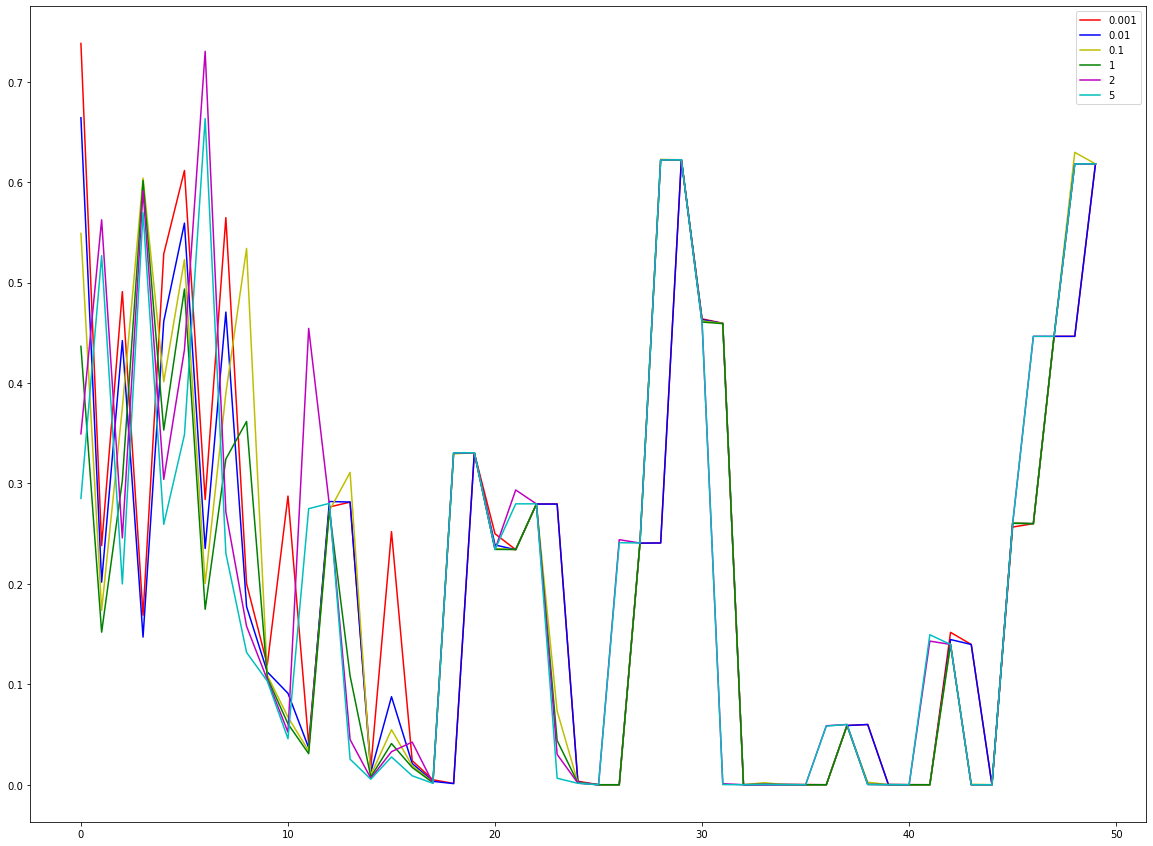

In [55]:
plt.figure(figsize=(20,15))

colors = ["r", "b", "y", "g", "m", "c"]

for k in range(len(colors)):
    plt.plot(sgd_loss_descent_train[:,k], label=str(learning_rates[k]), color=colors[k])
    
plt.legend()
plt.show()

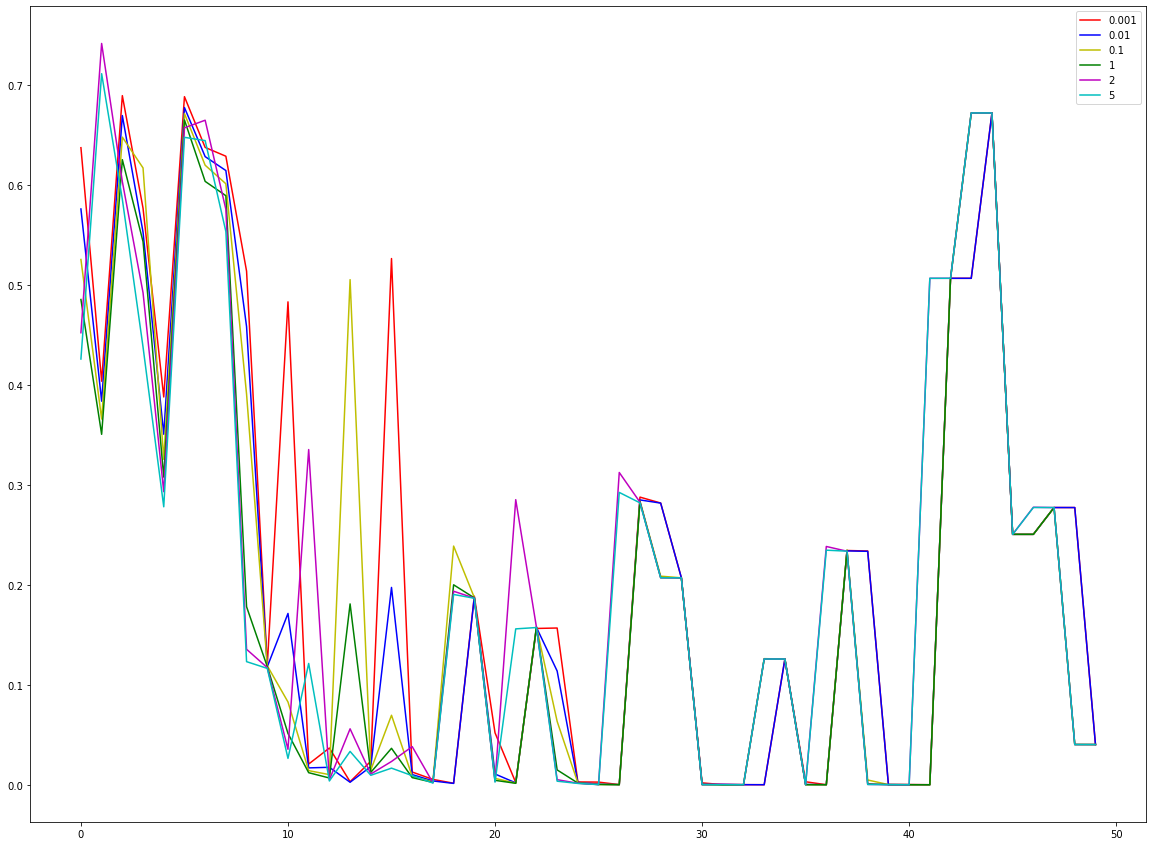

In [56]:
plt.figure(figsize=(20,15))

colors = ["r", "b", "y", "g", "m", "c"]

for k in range(len(colors)):
    plt.plot(sgd_loss_descent_test[:,k], label=str(learning_rates[k]), color=colors[k])
    
plt.legend()
plt.show()

- On observe bien que le SGD converge plus vite que le GD.